# Analyse des Données - Cas Sixt

## 1. Compréhension du Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des fichiers CSV générés
clients = pd.read_csv("clients.csv")
locations = pd.read_csv("locations.csv")
paiements = pd.read_csv("paiements.csv")
avis_clients = pd.read_csv("avis_clients.csv")

### Combien de lignes et de colonnes contient chaque table ?

In [ ]:
print("Clients:")
print(f"Lignes: {clients.shape[0]}, Colonnes: {clients.shape[1]}")
print("\nLocations:")
print(f"Lignes: {locations.shape[0]}, Colonnes: {locations.shape[1]}")
print("\nPaiements:")
print(f"Lignes: {paiements.shape[0]}, Colonnes: {paiements.shape[1]}")
print("\nAvis Clients:")
print(f"Lignes: {avis_clients.shape[0]}, Colonnes: {avis_clients.shape[1]}")

Clients:
Lignes: 5000, Colonnes: 11

Locations:
Lignes: 10000, Colonnes: 12

Paiements:
Lignes: 10000, Colonnes: 18

Avis Clients:
Lignes: 4509, Colonnes: 6


### Listez les types de variables et identifiez les modifications nécessaires.

In [ ]:
print(clients.dtypes)
print(locations.dtypes)
print(paiements.dtypes)
print(avis_clients.dtypes)

client_id                   int64
date_inscription           object
genre                      object
age                         int64
type_client                object
ville                      object
pays                       object
programme_fidelite           bool
nombre_locations_total      int64
revenu_annuel             float64
métier                     object
dtype: object
location_id                     int64
client_id                       int64
date_location                  object
duree_location                  int64
type_vehicule                  object
type_carburant                 object
lieu_location                  object
kilométrage                   float64
prix_total                    float64
remise_appliquee                 bool
programme_fidelite_utilise       bool
premiere_location                bool
dtype: object
location_id                     int64
client_id                       int64
date_location                  object
duree_location              

### Convertissez les colonnes contenant des dates au format datetime pour faciliter l'analyse temporelle.

In [ ]:
date_cols = ["date_inscription", "date_location", "date_paiement", "date_avis"]
for df in [clients, locations, paiements, avis_clients]:
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])

## 2. Nettoyage et traitement des données

### Supprimez les éventuels doublons dans chaque table pour éviter les biais dans l'analyse.

In [ ]:
clients.drop_duplicates(inplace=True)
locations.drop_duplicates(inplace=True)
paiements.drop_duplicates(inplace=True)
avis_clients.drop_duplicates(inplace=True)

### Identifiez et analysez les valeurs manquantes.

In [ ]:
print(clients.isna().sum())
print(locations.isna().sum())
print(paiements.isna().sum())
print(avis_clients.isna().sum())

client_id                   0
date_inscription            0
genre                       0
age                         0
type_client                 0
ville                       0
pays                        0
programme_fidelite          0
nombre_locations_total      0
revenu_annuel             496
métier                      0
dtype: int64
location_id                     0
client_id                       0
date_location                   0
duree_location                  0
type_vehicule                   0
type_carburant                  0
lieu_location                   0
kilométrage                   760
prix_total                      0
remise_appliquee                0
programme_fidelite_utilise      0
premiere_location               0
dtype: int64
location_id                      0
client_id                        0
date_location                    0
duree_location                   0
type_vehicule                    0
type_carburant                   0
lieu_location             

### Remplacez les valeurs manquantes critiques et conservez celles qui sont pertinentes pour l'analyse.

Remplacez les valeurs manquantes suivantes :
  - 'ville' : Remplacez par "Inconnue".
  - 'métier' : Remplacez par "Inconnu".

- Conservez les NaN pour :
  - 'revenu_annuel' : Remplacez par la une valeur de la colonne comme la médiane pourrait fausser les analyses.
  - 'kilométrage' : Remplacez par une valeur de la colonne comme la médiane pourrait fausser les analyses.
  - 'date_paiement' : Peut être utile pour identifier les paiements en attente.
  - 'commentaire' : Permet d’analyser le taux de clients laissant un avis.

In [ ]:
clients.fillna({"ville": "Inconnue", "métier": "Inconnu"}, inplace=True)

### Identifiez les clés de jointure entre les différentes tables.

In [ ]:
print("Clés de jointure possibles:")
print("- 'client_id' présent dans clients, locations, paiements, avis_clients")
print("- 'location_id' présent dans locations, paiements, avis_clients")

Clés de jointure possibles:
- 'client_id' présent dans clients, locations, paiements, avis_clients
- 'location_id' présent dans locations, paiements, avis_clients


###  Consolidez les bases de données en une seule Master Database après le nettoyage.

In [ ]:
master_df = locations.merge(clients, on="client_id", how="left")
master_df = master_df.merge(paiements, on="location_id", how="left", suffixes=("", "_paiement"))
master_df = master_df.merge(avis_clients, on="location_id", how="left", suffixes=("", "_avis"))

In [ ]:
master_df.head()

,location_id,client_id,date_location,duree_location,type_vehicule,type_carburant,lieu_location,kilométrage,prix_total,remise_appliquee,...,date_paiement,montant_paye,type_paiement,statut_paiement,remise_appliquée_en_%,avis_id,client_id_avis,note,commentaire,date_avis
0,1,4919,2025-01-31,15,Citadine,Diesel,Gare,497.0,932.07,True,...,2025-01-31,932.07,Carte bancaire,Réussi,14.0,5179.0,4919.0,5.0,Parfait de A à Z !,2025-02-20
1,2,14,2024-11-25,9,Citadine,Essence,Aéroport,231.0,675.40,False,...,2024-11-24,675.40,Carte bancaire,Réussi,NaN,2895.0,14.0,5.0,Excellent service !,2024-12-07
2,3,440,2024-12-01,21,Citadine,Hybride,Centre-ville,453.0,896.70,False,...,2024-11-30,896.70,Virement,Réussi,NaN,NaN,NaN,NaN,NaN,NaT
3,4,4089,2024-11-11,2,Citadine,Essence,Gare,944.0,185.61,False,...,2024-11-10,185.61,Carte bancaire,Réussi,NaN,NaN,NaN,NaN,NaN,NaT
4,5,4554,2024-02-26,25,Berline,Hybride,Aéroport,173.0,1218.55,False,...,2024-02-25,1218.55,PayPal,Réussi,NaN,NaN,NaN,NaN,NaN,NaT


## 3. Analyses statistiques

###  Aanalyser les statistiques descriptives des variables numériques pour comprendre leur distribution.

*Utiliser les variables numériques suivantes : "revenu_annuel", "prix_total", "kilométrage", "duree_location", "montant_paye", "note"*

In [ ]:
stat = master_df[["revenu_annuel", "prix_total", "kilométrage", "duree_location", "montant_paye", "note"]].describe().round(2)
stat

,revenu_annuel,prix_total,kilométrage,duree_location,montant_paye,note
count,8984.00,10000.00,9240.00,10000.00,10000.00,4509.00
mean,49590.16,1165.50,523.60,15.47,1165.50,4.44
std,17221.25,797.86,273.60,8.63,797.86,0.86
min,20027.00,30.17,50.00,1.00,30.17,1.00
25%,34847.50,522.78,286.00,8.00,522.78,4.00
50%,49334.00,1009.45,520.00,15.00,1009.45,5.00
75%,64331.00,1677.28,759.25,23.00,1677.28,5.00
max,79999.00,3599.13,999.00,30.00,3599.13,5.00


### Analysez les variables catégoriques en affichant la fréquence des valeurs uniques.

In [ ]:
master_df[["type_vehicule", "lieu_location", "programme_fidelite", "statut_paiement"]].describe()

,type_vehicule,lieu_location,programme_fidelite,statut_paiement
count,10000,10000,10000,10000
unique,4,3,2,2
top,Citadine,Aéroport,False,Réussi
freq,4031,4073,7153,9787


In [ ]:
print(master_df["type_vehicule"].value_counts()), print("\n")
print(master_df["lieu_location"].value_counts()), print("\n")
print(master_df["programme_fidelite"].value_counts()), print("\n")
print(master_df["statut_paiement"].value_counts())

type_vehicule
Citadine      4031
SUV           2957
Berline       1976
Utilitaire    1036
Name: count, dtype: int64


lieu_location
Aéroport        4073
Centre-ville    2971
Gare            2956
Name: count, dtype: int64


programme_fidelite
False    7153
True     2847
Name: count, dtype: int64


statut_paiement
Réussi    9787
Échoué     213
Name: count, dtype: int64


## 4. Détection des Valeurs Extrêmes/Aberrantes

###  Identifiez les valeurs aberrantes/extrêmes en utilisant la méthode de l'écart interquartile (IQR).

In [ ]:
for x in ['revenu_annuel', 'prix_total', 'duree_location', 'note']:

      Q1 = np.quantile(master_df[x], 0.25)
      Q3 = np.quantile(master_df[x], 0.75)
      IQR = Q3 - Q1

      seuil_bas = Q1 - 1.5 * IQR
      seuil_haut = Q3 + 1.5 * IQR

      outliers = master_df[(master_df[x] < seuil_bas) | (master_df[x] > seuil_haut)]

      print('\n')
      display(outliers[[x]])

,revenu_annuel


,prix_total
394,3473.36
488,3573.98
621,3593.14
1229,3551.65
1603,3415.36
2365,3473.97
2379,3452.30
2433,3434.11
2487,3460.10
2585,3512.01


,duree_location


,note


In [ ]:
      Q1 = np.quantile(master_df['prix_total'], 0.25)
      Q3 = np.quantile(master_df['prix_total'], 0.75)
      IQR = Q3 - Q1

      seuil_bas = Q1 - 1.5 * IQR
      seuil_haut = Q3 + 1.5 * IQR

      outliers_pt = master_df[(master_df['prix_total'] < seuil_bas) | (master_df['prix_total'] > seuil_haut)]


      outliers_pt[['prix_total']]

,prix_total
394,3473.36
488,3573.98
621,3593.14
1229,3551.65
1603,3415.36
2365,3473.97
2379,3452.30
2433,3434.11
2487,3460.10
2585,3512.01


In [ ]:
outliers_pt

,location_id,client_id,date_location,duree_location,type_vehicule,type_carburant,lieu_location,kilométrage,prix_total,remise_appliquee,...,date_paiement,montant_paye,type_paiement,statut_paiement,remise_appliquée_en_%,avis_id,client_id_avis,note,commentaire,date_avis
394,395,1025,2024-12-29,29,SUV,Essence,Gare,484.0,3473.36,False,...,2024-12-28,3473.36,Virement,Réussi,NaN,NaN,NaN,NaN,NaN,NaT
488,489,2981,2024-11-10,30,Citadine,Essence,Gare,568.0,3573.98,True,...,2024-11-08,3573.98,Carte bancaire,Réussi,16.0,NaN,NaN,NaN,NaN,NaT
621,622,2025,2024-10-26,30,Berline,Diesel,Gare,597.0,3593.14,False,...,2024-10-26,3593.14,Carte bancaire,Réussi,NaN,NaN,NaN,NaN,NaN,NaT
1229,1230,915,2024-05-30,30,SUV,Diesel,Aéroport,640.0,3551.65,False,...,2024-05-30,3551.65,PayPal,Réussi,NaN,1953.0,915.0,5.0,Je reviendrai sans hésiter,2024-07-03
1603,1604,4757,2024-09-17,30,Berline,Électrique,Aéroport,525.0,3415.36,False,...,2024-09-16,3415.36,Carte bancaire,Réussi,NaN,NaN,NaN,NaN,NaN,NaT
2365,2366,1460,2024-11-02,29,Citadine,Diesel,Gare,809.0,3473.97,False,...,2024-11-02,3473.97,Virement,Réussi,NaN,2751.0,1460.0,5.0,Je reviendrai sans hésiter,2024-12-08
2379,2380,4773,2025-01-18,30,SUV,Hybride,Aéroport,843.0,3452.30,False,...,2025-01-18,3452.30,PayPal,Réussi,NaN,3272.0,4773.0,5.0,Excellent service !,2025-02-24
2433,2434,3510,2024-03-01,29,SUV,Essence,Aéroport,703.0,3434.11,False,...,2024-03-01,3434.11,Carte bancaire,Réussi,NaN,NaN,NaN,NaN,NaN,NaT
2487,2488,253,2024-04-09,29,SUV,Hybride,Aéroport,407.0,3460.10,False,...,2024-04-07,3460.10,Carte bancaire,Réussi,NaN,2212.0,253.0,4.0,Très bonne expérience,2024-05-12
2585,2586,1996,2024-11-01,30,Berline,Essence,Aéroport,423.0,3512.01,False,...,2024-11-01,3512.01,Carte bancaire,Réussi,NaN,4704.0,1996.0,4.0,Voiture récente et propre,2024-12-05


In [ ]:
master_df['note'].unique()

array([ 5., nan,  4.,  3.,  2.,  1.])

In [ ]:
master_df['note'].value_counts()

,count
note,
5.0,2696
4.0,1373
3.0,236
2.0,121
1.0,83


In [ ]:
print(master_df['note'].isna().sum())

5491


In [ ]:
master_df.fillna(0, inplace=True) # les nan on a remplacé par la median on les ai considéré comme des valeur neutre

<ipython-input-252-89eed6cc6147>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  master_df.fillna(0, inplace=True) # les nan on a remplacé par la median on les ai considéré comme des valeur neutre


In [ ]:
master_df['note'].value_counts()

,count
note,
0.0,5491
5.0,2696
4.0,1373
3.0,236
2.0,121
1.0,83


### Visualisez les valeurs aberrantes/extrêmes à l'aide de boxplots pour chaque variable concernée.

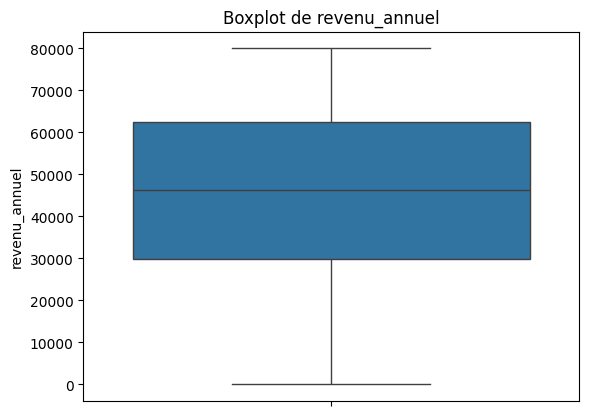

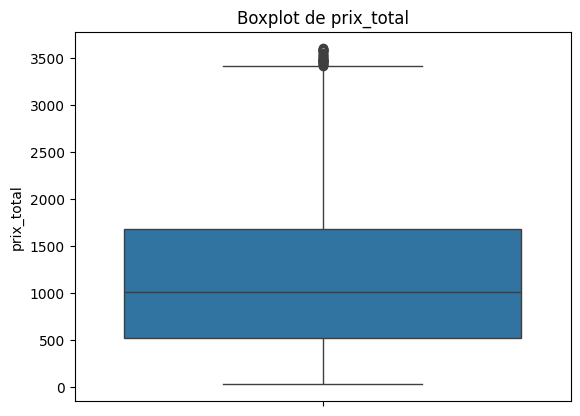

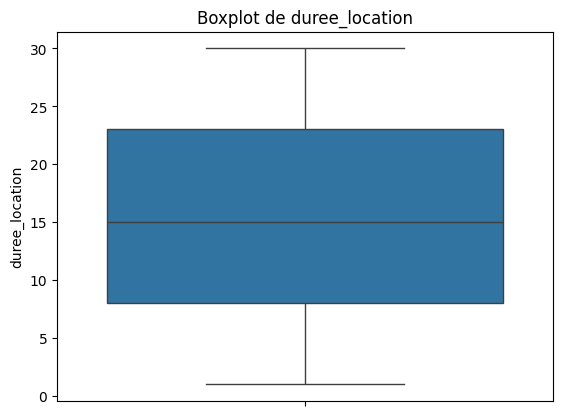

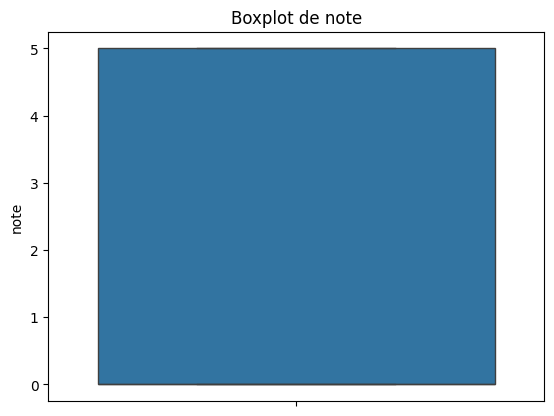

In [ ]:
for i in master_df[['revenu_annuel', 'prix_total', 'duree_location', 'note']]:
    sns.boxplot(y=master_df[i])
    plt.title(f"Boxplot de {i}")
    plt.show()

###  Supprimer les lignes contenant des valeurs aberrantes/extrêmes dans ces colonnes est une bonne idée ou non ?

In [ ]:
classe_duree = []
for x in master_df['duree_location']:
  if x <8:
    classe_duree.append("- d'une semaine")
  elif 7 < x < 15:
    classe_duree.append("1 à 2 semaines")
  elif 14 < x < 22:
    classe_duree.append("2 à 3 semaines")
  else:
    classe_duree.append("3 semaines et +")
master_df['classe_durée'] = classe_duree
master_df.head()

,location_id,client_id,date_location,duree_location,type_vehicule,type_carburant,lieu_location,kilométrage,prix_total,remise_appliquee,...,montant_paye,type_paiement,statut_paiement,remise_appliquée_en_%,avis_id,client_id_avis,note,commentaire,date_avis,classe_durée
0,1,4919,2025-01-31,15,Citadine,Diesel,Gare,497.0,932.07,True,...,932.07,Carte bancaire,Réussi,14.0,5179.0,4919.0,5.0,Parfait de A à Z !,2025-02-20 00:00:00,2 à 3 semaines
1,2,14,2024-11-25,9,Citadine,Essence,Aéroport,231.0,675.40,False,...,675.40,Carte bancaire,Réussi,0.0,2895.0,14.0,5.0,Excellent service !,2024-12-07 00:00:00,1 à 2 semaines
2,3,440,2024-12-01,21,Citadine,Hybride,Centre-ville,453.0,896.70,False,...,896.70,Virement,Réussi,0.0,0.0,0.0,0.0,0,0,2 à 3 semaines
3,4,4089,2024-11-11,2,Citadine,Essence,Gare,944.0,185.61,False,...,185.61,Carte bancaire,Réussi,0.0,0.0,0.0,0.0,0,0,- d'une semaine
4,5,4554,2024-02-26,25,Berline,Hybride,Aéroport,173.0,1218.55,False,...,1218.55,PayPal,Réussi,0.0,0.0,0.0,0.0,0,0,3 semaines et +


In [ ]:
master_df['classe_durée'].value_counts()

,count
classe_durée,
3 semaines et +,2976
1 à 2 semaines,2392
2 à 3 semaines,2326
- d'une semaine,2306


In [ ]:
valeur_abb = master_df.groupby('classe_durée').agg({"prix_total" : "mean",
                                          "duree_location" : "mean",
                                                    'kilométrage': 'mean'}).reset_index().round(2)
valeur_abb

,classe_durée,prix_total,duree_location,kilométrage
0,- d'une semaine,300.81,3.99,485.83
1,1 à 2 semaines,822.97,10.99,487.90
2,2 à 3 semaines,1345.46,17.95,477.81
3,3 semaines et +,1970.17,26.02,483.64


In [ ]:
# je pense que c'est pas une bone idée de les supriméé vu que les valeurs extrêmes sont trés proche de notre sueil hautet du coup on va les garder

## 5. Analyse des Corrélations

### Calculez et affichez la matrice de corrélation.

In [ ]:
master_mat2 = master_df[["prix_total", "kilométrage", "duree_location"]].corr()
master_mat2

,prix_total,kilométrage,duree_location
prix_total,1.000000,0.000450,0.819189
kilométrage,0.000450,1.000000,-0.004869
duree_location,0.819189,-0.004869,1.000000


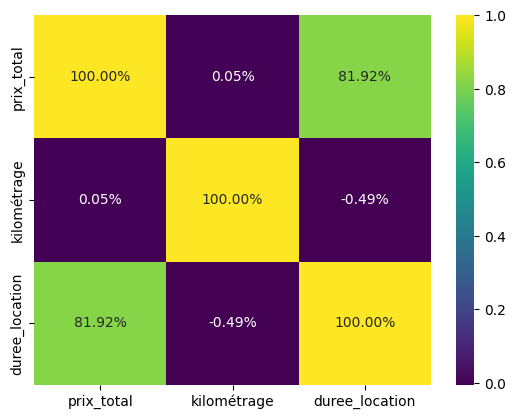

In [ ]:
sns.heatmap(master_mat2,
            annot= True,
            fmt= '.2%',
            cmap= 'viridis')

plt.show()

In [ ]:
master_mat = master_df[["revenu_annuel", "prix_total", "kilométrage", "duree_location", "montant_paye", "note"]].corr()
master_mat

,revenu_annuel,prix_total,kilométrage,duree_location,montant_paye,note
revenu_annuel,1.000000,-0.005720,0.013541,0.005547,-0.005720,-0.001212
prix_total,-0.005720,1.000000,0.000450,0.819189,1.000000,0.010448
kilométrage,0.013541,0.000450,1.000000,-0.004869,0.000450,-0.001259
duree_location,0.005547,0.819189,-0.004869,1.000000,0.819189,-0.000408
montant_paye,-0.005720,1.000000,0.000450,0.819189,1.000000,0.010448
note,-0.001212,0.010448,-0.001259,-0.000408,0.010448,1.000000


## 6. Visualisation des Données

### Affichez la matrice de corrélation sous forme de heatmap.

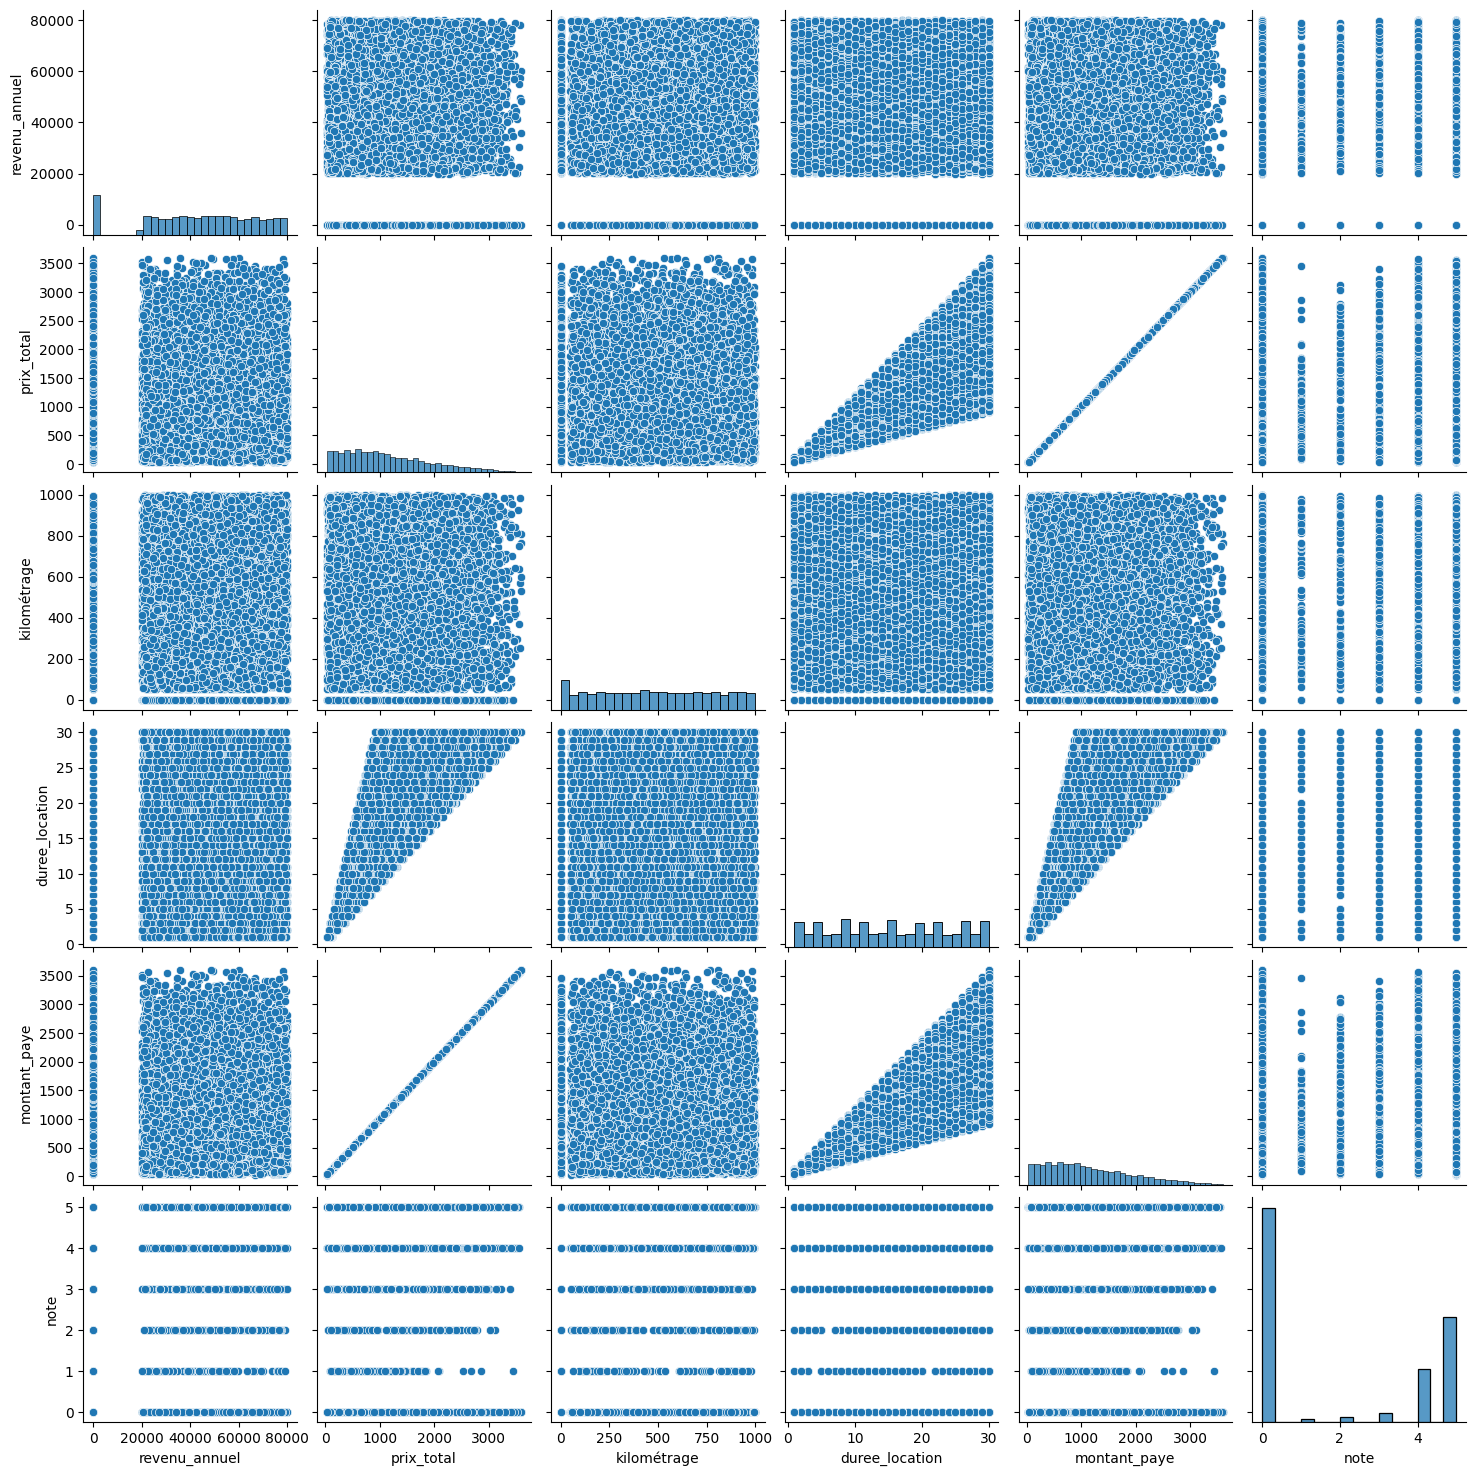

In [ ]:
sns.pairplot(master_df[["revenu_annuel", "prix_total", "kilométrage", "duree_location", "montant_paye", "note"]])

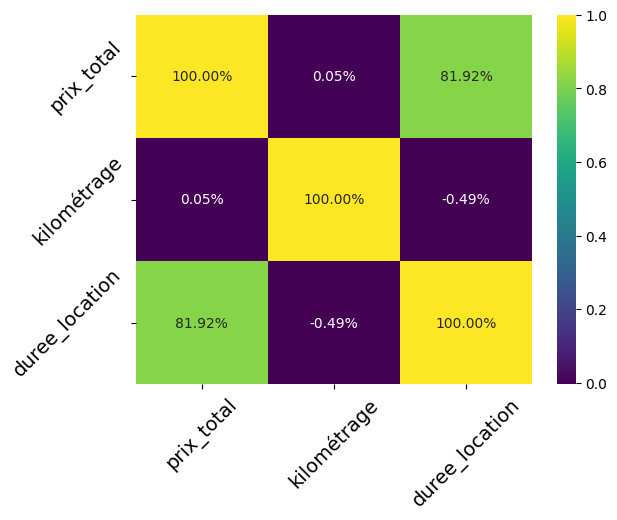

In [ ]:
sns.heatmap(master_mat2,
            annot= True,
            fmt= '.2%',
            cmap= 'viridis')
plt.yticks(rotation= 45, # Même chose avec l'axe des ordonnées.
            fontsize= 14 )
plt.xticks(rotation= 45, # Même chose avec l'axe des ordonnées.
            fontsize= 14 )
plt.show()

###  Visualisez la distribution des principales variables numériques.


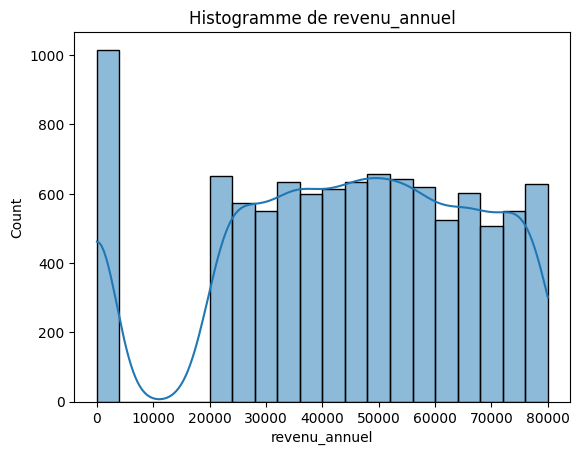

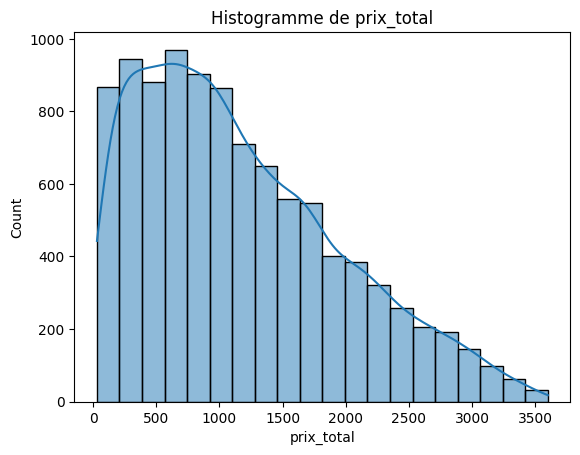

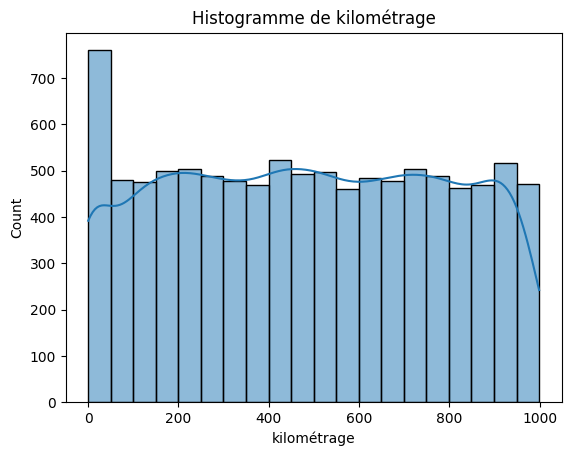

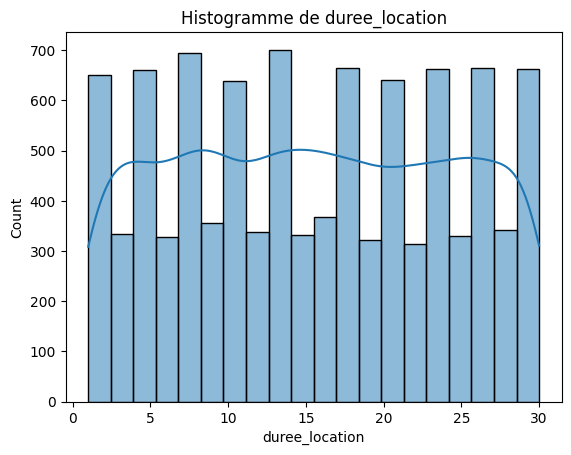

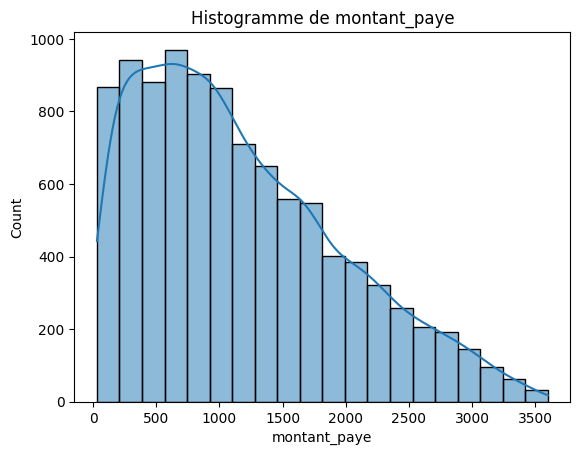

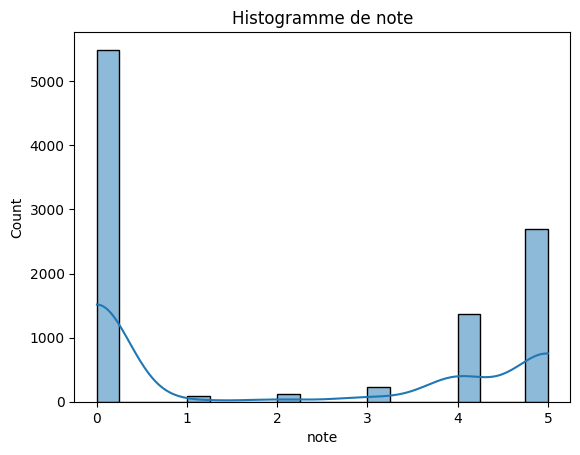

In [ ]:
for x in ["revenu_annuel", "prix_total", "kilométrage", "duree_location", "montant_paye", "note"]:
  sns.histplot(master_df[x], kde=True, bins=20)
  plt.title(f"Histogramme de {x}")
  plt.show()

### Compléter vos analyses
Vous pourrez par exemple :

*  Analysez les tendances temporelles des locations.
*  Représentez les relations entre variables à l’aide de scatter plots.
* Représentez les variables catégoriques avec des diagrammes en barres.
* Affichez la répartition des paiements sous forme de camembert.

# **Analysez les tendances temporelles des locations.**

In [ ]:
master_df.columns

Index(['location_id', 'client_id', 'date_location', 'duree_location',
       'type_vehicule', 'type_carburant', 'lieu_location', 'kilométrage',
       'prix_total', 'remise_appliquee', 'programme_fidelite_utilise',
       'premiere_location', 'date_inscription', 'genre', 'age', 'type_client',
       'ville', 'pays', 'programme_fidelite', 'nombre_locations_total',
       'revenu_annuel', 'métier', 'client_id_paiement',
       'date_location_paiement', 'duree_location_paiement',
       'type_vehicule_paiement', 'type_carburant_paiement',
       'lieu_location_paiement', 'kilométrage_paiement', 'prix_total_paiement',
       'remise_appliquee_paiement', 'programme_fidelite_utilise_paiement',
       'premiere_location_paiement', 'paiement_id', 'date_paiement',
       'montant_paye', 'type_paiement', 'statut_paiement',
       'remise_appliquée_en_%', 'avis_id', 'client_id_avis', 'note',
       'commentaire', 'date_avis', 'mois'],
      dtype='object')

In [ ]:
# Analysez les tendances temporelles des locations et Savoir quand la demande est haute ou basse

master_df['mois'] = master_df['date_location'].dt.month#_name()
master_df.head()

,location_id,client_id,date_location,duree_location,type_vehicule,type_carburant,lieu_location,kilométrage,prix_total,remise_appliquee,...,statut_paiement,remise_appliquée_en_%,avis_id,client_id_avis,note,commentaire,date_avis,classe_durée,mois,cluster
0,1,4919,2025-01-31,15,Citadine,Diesel,Gare,497.0,932.07,True,...,Réussi,14.0,5179.0,4919.0,5.0,Parfait de A à Z !,2025-02-20 00:00:00,2 à 3 semaines,1,0
1,2,14,2024-11-25,9,Citadine,Essence,Aéroport,231.0,675.40,False,...,Réussi,0.0,2895.0,14.0,5.0,Excellent service !,2024-12-07 00:00:00,1 à 2 semaines,11,1
2,3,440,2024-12-01,21,Citadine,Hybride,Centre-ville,453.0,896.70,False,...,Réussi,0.0,0.0,0.0,0.0,0,0,2 à 3 semaines,12,1
3,4,4089,2024-11-11,2,Citadine,Essence,Gare,944.0,185.61,False,...,Réussi,0.0,0.0,0.0,0.0,0,0,- d'une semaine,11,0
4,5,4554,2024-02-26,25,Berline,Hybride,Aéroport,173.0,1218.55,False,...,Réussi,0.0,0.0,0.0,0.0,0,0,3 semaines et +,2,0


In [ ]:
a = master_df['mois'].value_counts()
a

,count
mois,
2,861
3,861
11,860
7,847
5,847
12,844
4,843
8,824
9,815


In [ ]:
df = master_df.groupby('mois').agg({"prix_total" : "sum",
                                              "note" : "mean",
                                              "duree_location" : "sum",
                                               'location_id': 'count'}).reset_index()

df

,mois,prix_total,note,duree_location,location_id
0,1,951156.51,1.962779,12451,806
1,2,1019701.41,1.975610,13402,861
2,3,966242.87,2.131243,12946,861
3,4,1021684.23,1.972716,13443,843
4,5,1012543.82,1.962220,13472,847
5,6,928621.49,1.895522,12593,804
6,7,1000359.23,1.950413,13131,847
7,8,939464.06,1.991505,12642,824
8,9,930678.26,2.168098,12250,815
9,10,928560.33,1.904822,12268,788


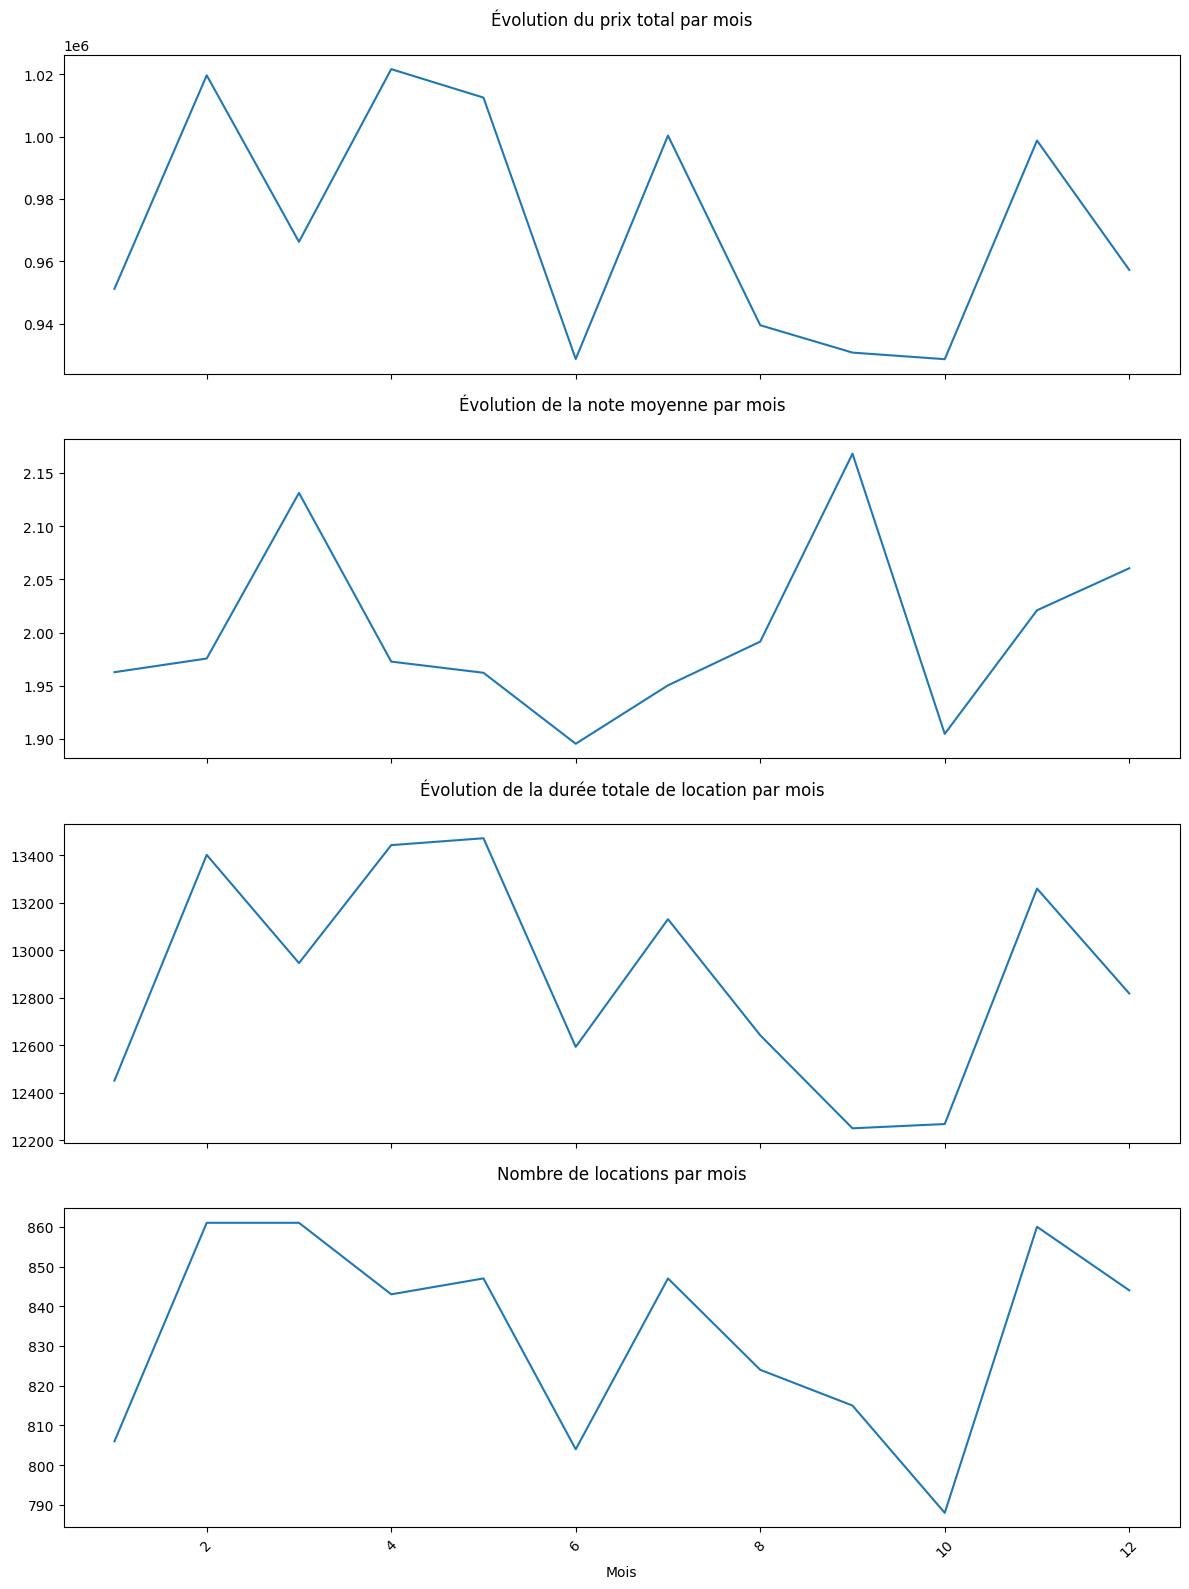

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que ton DataFrame s'appelle df_mois
# Si besoin, remplace par : df_mois = master_df_bis

# S'assurer que la colonne "mois" est bien de type date (ou string au bon format)
df_mois = df.copy()
#df_mois['mois'] = pd.to_datetime(df_mois['mois'])

# Tracer chaque variable par mois
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
print('\n')
sns.lineplot(data=df_mois, x='mois', y='prix_total', ax=axes[0])
axes[0].set_title('Évolution du prix total par mois\n')
ax.set_xlabel('Mois')
print('\n')
sns.lineplot(data=df_mois, x='mois', y='note', ax=axes[1])
axes[1].set_title('Évolution de la note moyenne par mois\n')
ax.set_xlabel('Mois')
print('\n')
sns.lineplot(data=df_mois, x='mois', y='duree_location', ax=axes[2])
axes[2].set_title('Évolution de la durée totale de location par mois\n')
ax.set_xlabel('Mois')
print('\n')
sns.lineplot(data=df_mois, x='mois', y='location_id', ax=axes[3])
axes[3].set_title('Nombre de locations par mois\n')
ax.set_xlabel('Mois')

# Formatage final
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('Mois')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


TypeError: Invalid object type at position 0

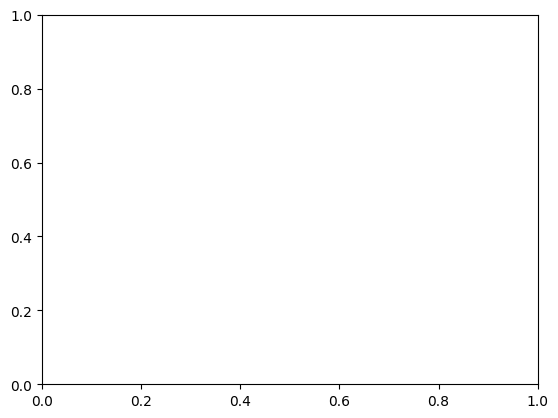

In [ ]:
sns.lineplot(data=master_df_bis, x='mois', y='location_id')
plt.yticks(rotation= 30, # Même chose avec l'axe des ordonnées.
            fontsize= 14)
plt.title("Evolution des chiffres d'affaires\n")
plt.show()

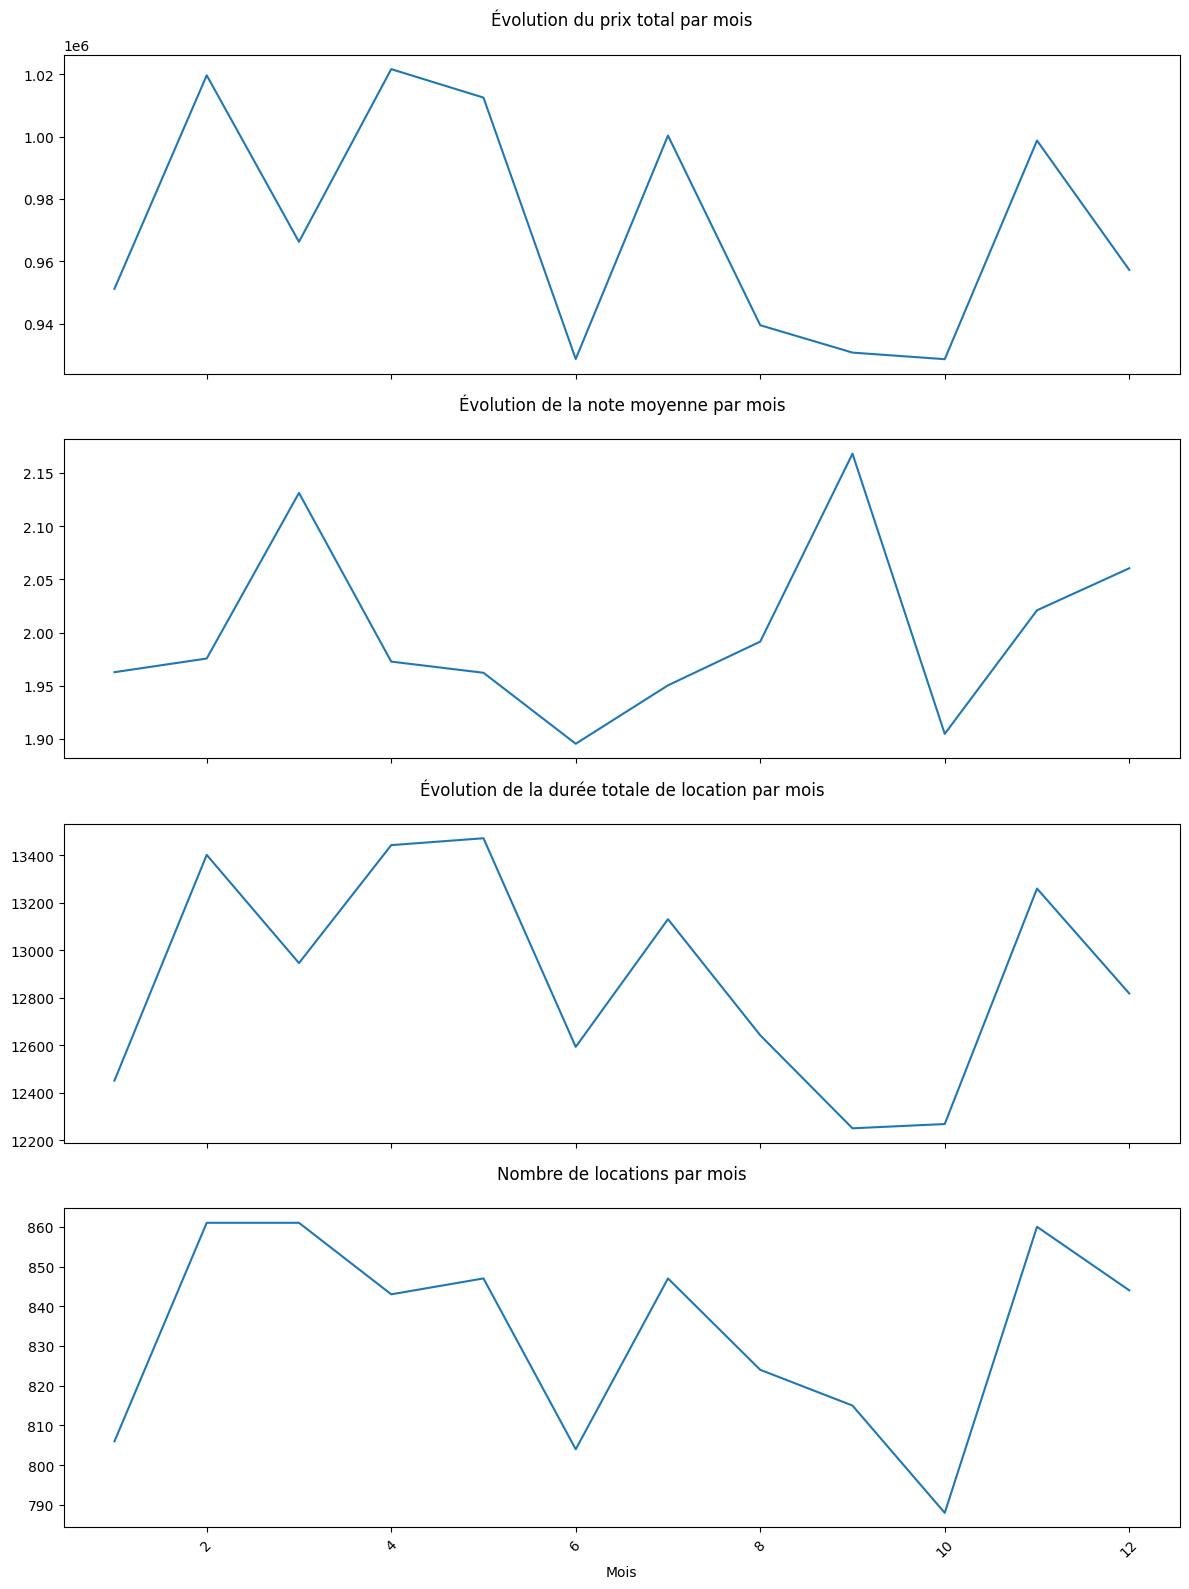

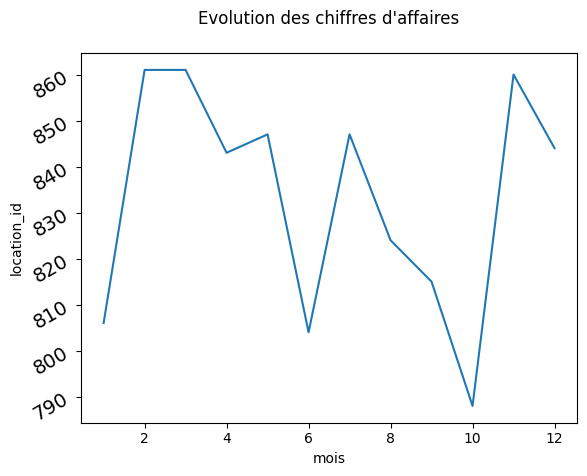

In [ ]:
# Analysez les tendances temporelles des locations et Savoir quand la demande est haute ou basse

master_df['mois'] = master_df['date_location'].dt.month#_name()
master_df.head()

a = master_df['mois'].value_counts()
a

df = master_df.groupby('mois').agg({"prix_total" : "sum",
                                              "note" : "mean",
                                              "duree_location" : "sum",
                                               'location_id': 'count'}).reset_index()

df

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que ton DataFrame s'appelle df_mois
# Si besoin, remplace par : df_mois = master_df_bis

# S'assurer que la colonne "mois" est bien de type date (ou string au bon format)
df_mois = df.copy()
#df_mois['mois'] = pd.to_datetime(df_mois['mois'])

# Tracer chaque variable par mois
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
print('\n')
sns.lineplot(data=df_mois, x='mois', y='prix_total', ax=axes[0])
axes[0].set_title('Évolution du prix total par mois\n')
# Corrected the ax.set_xlabel calls to axes[i].set_xlabel
axes[0].set_xlabel('Mois')
print('\n')
sns.lineplot(data=df_mois, x='mois', y='note', ax=axes[1])
axes[1].set_title('Évolution de la note moyenne par mois\n')
axes[1].set_xlabel('Mois')
print('\n')
sns.lineplot(data=df_mois, x='mois', y='duree_location', ax=axes[2])
axes[2].set_title('Évolution de la durée totale de location par mois\n')
axes[2].set_xlabel('Mois')
print('\n')
sns.lineplot(data=df_mois, x='mois', y='location_id', ax=axes[3])
axes[3].set_title('Nombre de locations par mois\n')
axes[3].set_xlabel('Mois')

# Formatage final
for ax in axes:
    ax.set_ylabel('')
    # Redundant due to individual setting above, but kept for completeness if needed
    # ax.set_xlabel('Mois')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Use the correct DataFrame `df` instead of the undefined `master_df_bis`
sns.lineplot(data=df, x='mois', y='location_id')
plt.yticks(rotation= 30, # Même chose avec l'axe des ordonnées.
            fontsize= 14)
plt.title("Evolution des chiffres d'affaires\n")
plt.show()

In [ ]:
master_df_bis2 = master_df.groupby('type_vehicule').agg({"prix_total" : "sum",
                                              "note" : "mean",
                                         "duree_location" : "sum" }).reset_index()

master_df_bis2


,type_vehicule,prix_total,note,duree_location
0,Berline,2371710.34,1.981781,30857
1,Citadine,4625536.52,1.974696,61840
2,SUV,3461513.34,2.017585,45814
3,Utilitaire,1196224.37,2.087838,16165


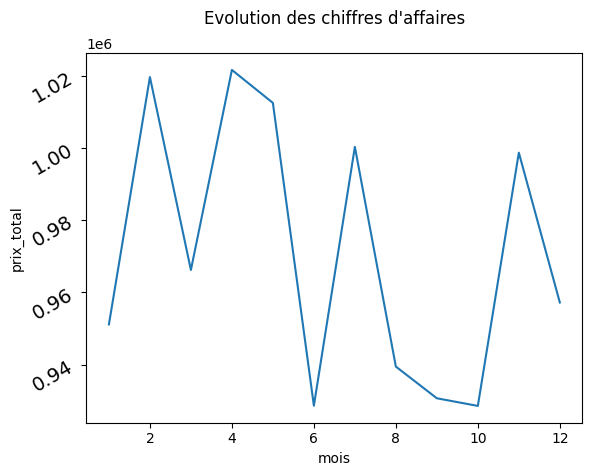

In [ ]:
sns.lineplot(data=master_df_bis, x='mois', y='prix_total')
plt.yticks(rotation= 30, # Même chose avec l'axe des ordonnées.
            fontsize= 14)
plt.title("Evolution des chiffres d'affaires\n")
plt.show()

In [ ]:
master_df.head()

,location_id,client_id,date_location,duree_location,type_vehicule,type_carburant,lieu_location,kilométrage,prix_total,remise_appliquee,...,montant_paye,type_paiement,statut_paiement,remise_appliquée_en_%,avis_id,client_id_avis,note,commentaire,date_avis,mois
0,1,4919,2025-01-31,15,Citadine,Diesel,Gare,497.0,932.07,True,...,932.07,Carte bancaire,Réussi,14.0,5179.0,4919.0,5.0,Parfait de A à Z !,2025-02-20,1
1,2,14,2024-11-25,9,Citadine,Essence,Aéroport,231.0,675.40,False,...,675.40,Carte bancaire,Réussi,NaN,2895.0,14.0,5.0,Excellent service !,2024-12-07,11
2,3,440,2024-12-01,21,Citadine,Hybride,Centre-ville,453.0,896.70,False,...,896.70,Virement,Réussi,NaN,NaN,NaN,NaN,NaN,NaT,12
3,4,4089,2024-11-11,2,Citadine,Essence,Gare,944.0,185.61,False,...,185.61,Carte bancaire,Réussi,NaN,NaN,NaN,NaN,NaN,NaT,11
4,5,4554,2024-02-26,25,Berline,Hybride,Aéroport,173.0,1218.55,False,...,1218.55,PayPal,Réussi,NaN,NaN,NaN,NaN,NaN,NaT,2


# **Représentez les relations entre variables à l’aide de scatter plots.**

<ipython-input-292-73760466ade6>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc= "best") # Positionne automatiquement la légende au meilleur endroit


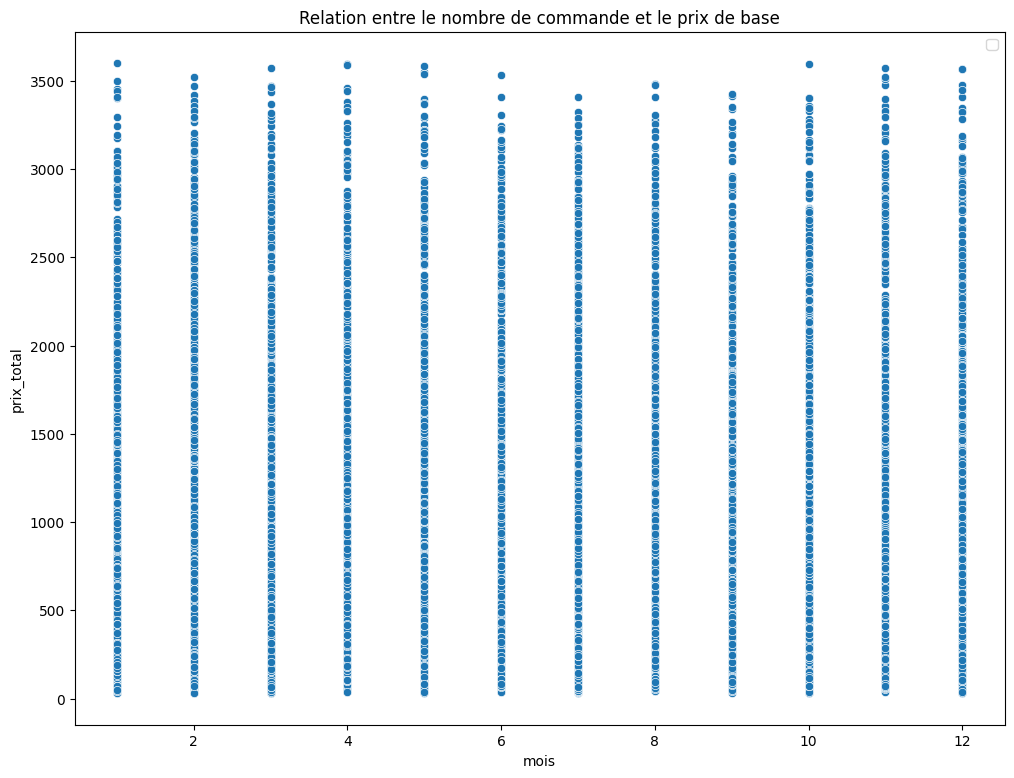

In [ ]:
# Scatter Plot : Prix de base vs nombre de commandes
plt.figure(figsize=(12, 9))

sns.scatterplot(data= master_df,
                y= "prix_total", x= "mois")

plt.title("Relation entre le nombre de commande et le prix de base")
plt.legend(loc= "best") # Positionne automatiquement la légende au meilleur endroit

plt.show()

# **Représentez les variables catégoriques avec des diagrammes en barres.**

<Axes: xlabel='type_vehicule', ylabel='count'>

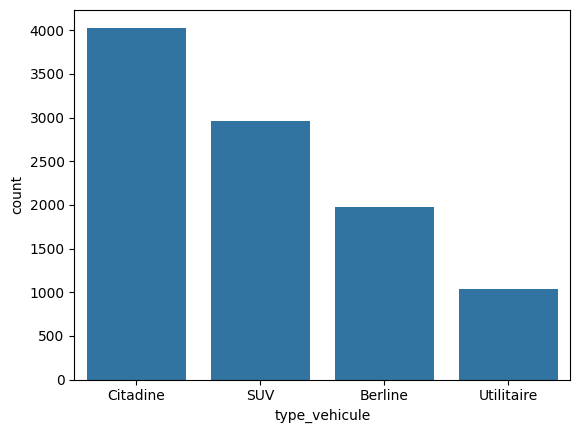

In [ ]:
sns.countplot(data=master_df, x='type_vehicule', order=master_df['type_vehicule'].value_counts().index)


<Axes: xlabel='type_carburant', ylabel='count'>

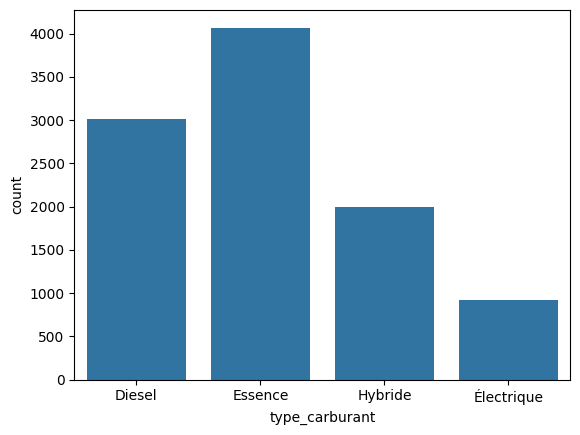

In [ ]:

sns.countplot(data=master_df, x='type_carburant')

<Axes: xlabel='lieu_location', ylabel='count'>

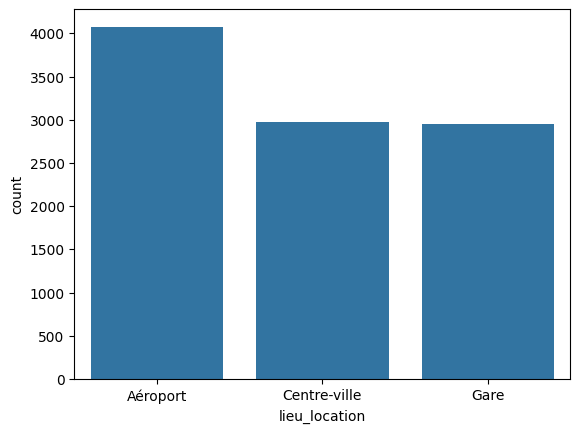

In [ ]:

sns.countplot(data=master_df, x='lieu_location', order=master_df['lieu_location'].value_counts().index)

<Axes: xlabel='type_paiement', ylabel='count'>

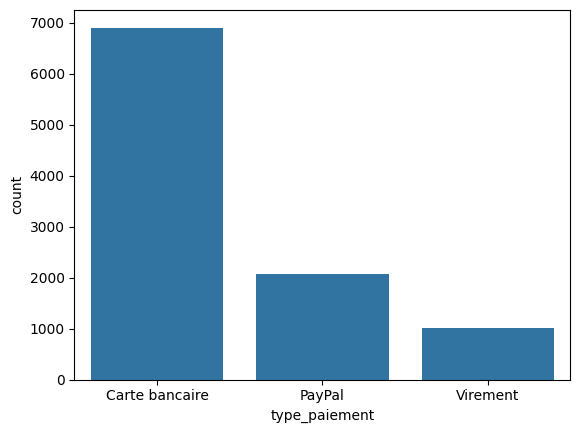

In [ ]:

sns.countplot(data=master_df, x='type_paiement', order=master_df['type_paiement'].value_counts().index)

<Axes: xlabel='statut_paiement', ylabel='count'>

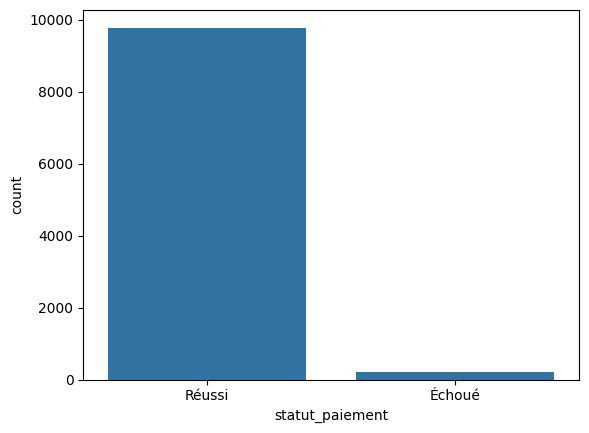

In [ ]:

sns.countplot(data=master_df, x='statut_paiement', order=master_df['statut_paiement'].value_counts().index)

**# la répartition des paiements sous forme de camembert.**


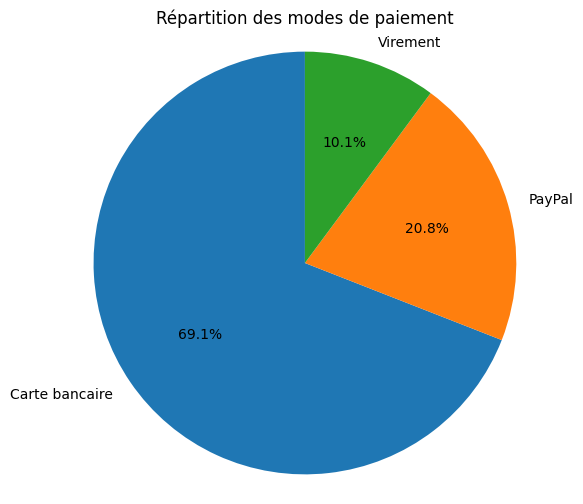

In [ ]:
paiements = master_df['type_paiement'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(paiements, labels=paiements.index, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des modes de paiement")
plt.axis('equal')  # Cercle parfait
plt.show()

In [ ]:
paiements.index

Index(['Carte bancaire', 'PayPal', 'Virement'], dtype='object', name='type_paiement')

In [ ]:
type_v = master_df['prix_totale'].value_counts() #ca par tipe de vi

plt.figure(figsize=(6, 6))
plt.pie(type_v, labels=type_v.index, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des types des vehicules")
plt.axis('equal')  # Cercle parfait
plt.show()

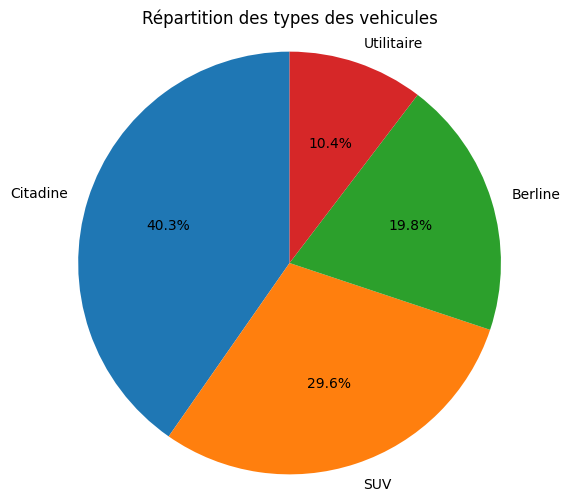

In [ ]:
type_v = master_df['type_vehicule'].value_counts() #ca par tipe de vi

plt.figure(figsize=(6, 6))
plt.pie(type_v, labels=type_v.index, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des types des vehicules")
plt.axis('equal')  # Cercle parfait
plt.show()

In [ ]:
from sklearn.cluster import KMeans
X = master_df[['revenu_annuel', 'duree_location', 'prix_total']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
master_df['cluster'] = kmeans.labels_


In [ ]:
groupe = master_df.groupby('cluster')['prix_total'].mean()

,prix_total
cluster,
0,1162.697755
1,1166.082493
2,1175.632057


In [ ]:
sns.scatterplot(x='revenu_annuel', y='prix_total', hue='cluster')

ValueError: Could not interpret value `revenu_annuel` for `x`. Value is a string, but `data` was not passed.

## 7. Insights Business et Prises de Décision

Variance expliquée par chaque composante : [0.45625368 0.25273166]


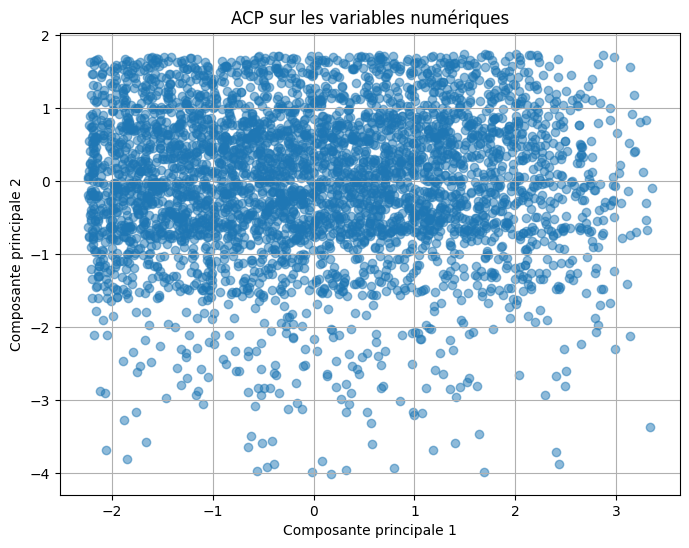

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Suppose que ton DataFrame s'appelle master_df
colonnes = ['revenu_annuel', 'prix_total', 'duree_location', 'note']
X = master_df[colonnes].dropna()  # Nettoyage des données

# 1. Standardiser les données (très important pour l’ACP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Appliquer l’ACP
pca = PCA(n_components=2)  # On réduit à 2 dimensions
X_pca = pca.fit_transform(X_scaled)

# 3. Résultats
print("Variance expliquée par chaque composante :", pca.explained_variance_ratio_)

# 4. Visualiser
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("ACP sur les variables numériques")
plt.grid(True)
plt.show()


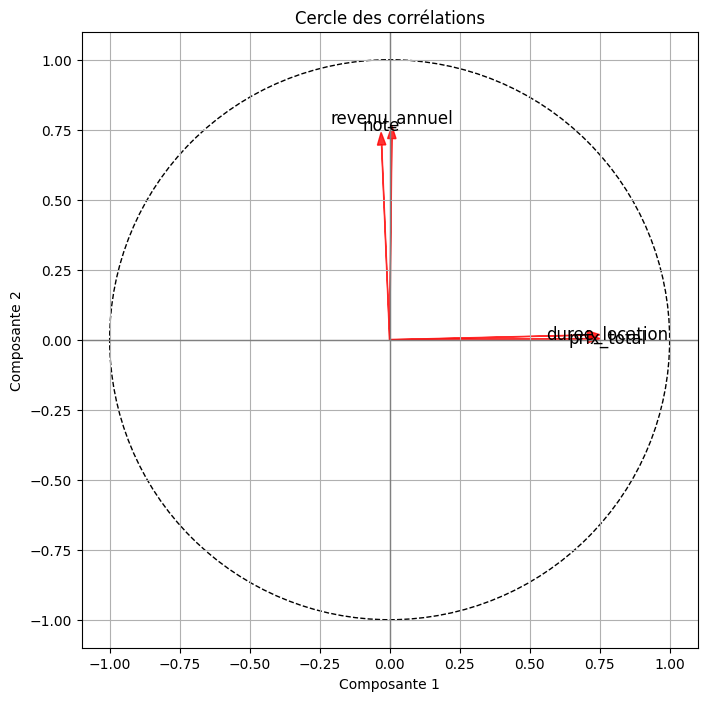

In [ ]:
import numpy as np

# On récupère les composantes (vecteurs propres) de PCA
components = pca.components_  # shape: (n_components, n_features)
features = colonnes           # ['revenu_annuel', 'prix_total', 'duree_location', 'note']

# On trace le cercle
plt.figure(figsize=(8,8))
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='black', linestyle='--')
plt.gca().add_artist(circle)

# Flèches pour chaque variable
for i in range(len(features)):
    plt.arrow(0, 0,
              components[0, i], components[1, i],
              color='red', alpha=0.8, head_width=0.03)
    plt.text(components[0, i]*1.1, components[1, i]*1.1, features[i],
             color='black', ha='center', va='center', fontsize=12)

# Paramètres du graphique
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.title("Cercle des corrélations")
plt.grid()
plt.gca().set_aspect('equal')
plt.show()


In [ ]:
Qk1 = np.quantile(master_df['kilométrage'], 0.25)
Qk2 = np.quantile(master_df['kilométrage'], 0.5)
Qk3 = np.quantile(master_df['kilométrage'], 0.75)




count    10000.00000
mean         2.00050
std          2.28132
min          0.00000
25%          0.00000
50%          0.00000
75%          5.00000
max          5.00000
Name: note, dtype: float64


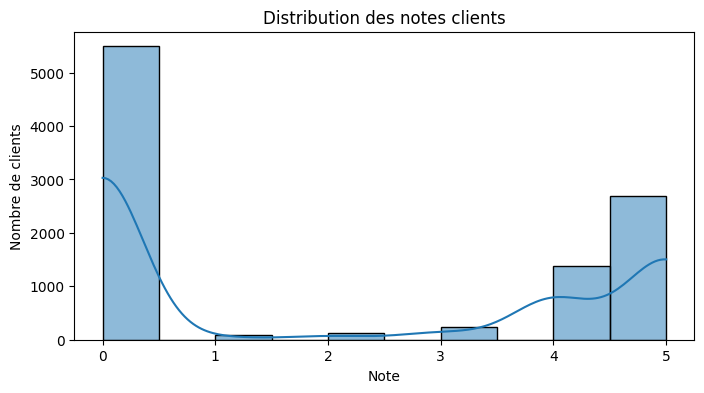

In [ ]:
# Statistiques de base
print(master_df['note'].describe())

# Distribution de la note
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(master_df['note'], bins=10, kde=True)
plt.title('Distribution des notes clients')
plt.xlabel('Note')
plt.ylabel('Nombre de clients')
plt.show()


In [ ]:
master_df['date_location'] = pd.to_datetime(master_df['date_location'])

# Extraire les composantes temporelles
master_df['mois'] = master_df['date_location'].dt.to_period('M').astype(str)
master_df['jour_semaine'] = master_df['date_location'].dt.day_name()
master_df['semaine'] = master_df['date_location'].dt.isocalendar().week


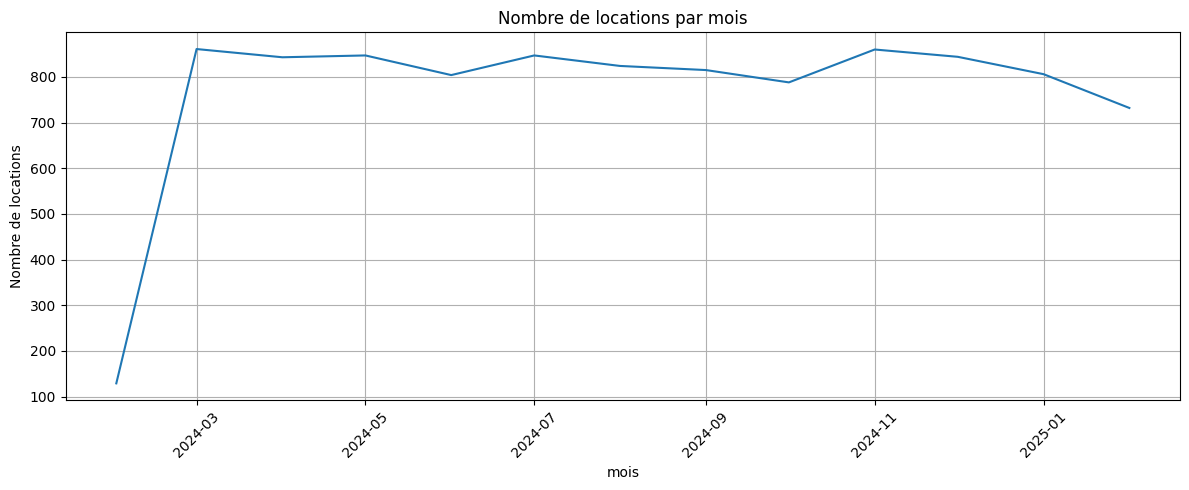

In [ ]:
locations_par_mois = master_df.groupby('mois')['location_id'].count().reset_index()
locations_par_mois.columns = ['mois', 'nb_locations']
locations_par_mois['mois'] = pd.to_datetime(locations_par_mois['mois'])

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.lineplot(data=locations_par_mois.sort_values('mois'), x='mois', y='nb_locations')
plt.title("Nombre de locations par mois")
plt.ylabel("Nombre de locations")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


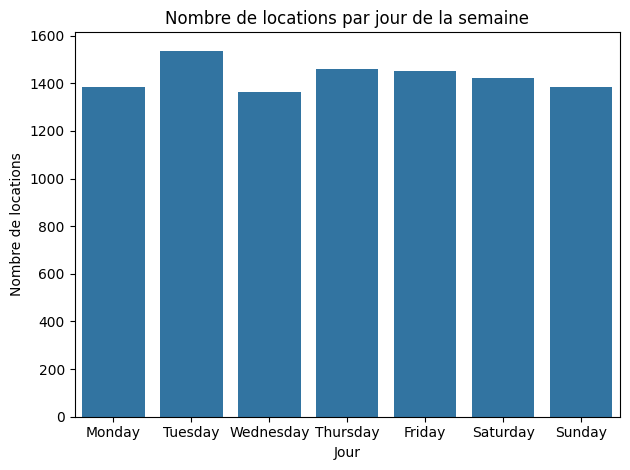

In [ ]:
locations_jour = master_df.groupby('jour_semaine')['location_id'].count().reset_index()
locations_jour.columns = ['jour', 'nb_locations']

# Ordre logique des jours
jours_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
locations_jour['jour'] = pd.Categorical(locations_jour['jour'], categories=jours_order, ordered=True)
locations_jour = locations_jour.sort_values('jour')

sns.barplot(data=locations_jour, x='jour', y='nb_locations')
plt.title("Nombre de locations par jour de la semaine")
plt.ylabel("Nombre de locations")
plt.xlabel("Jour")
plt.tight_layout()
plt.show()


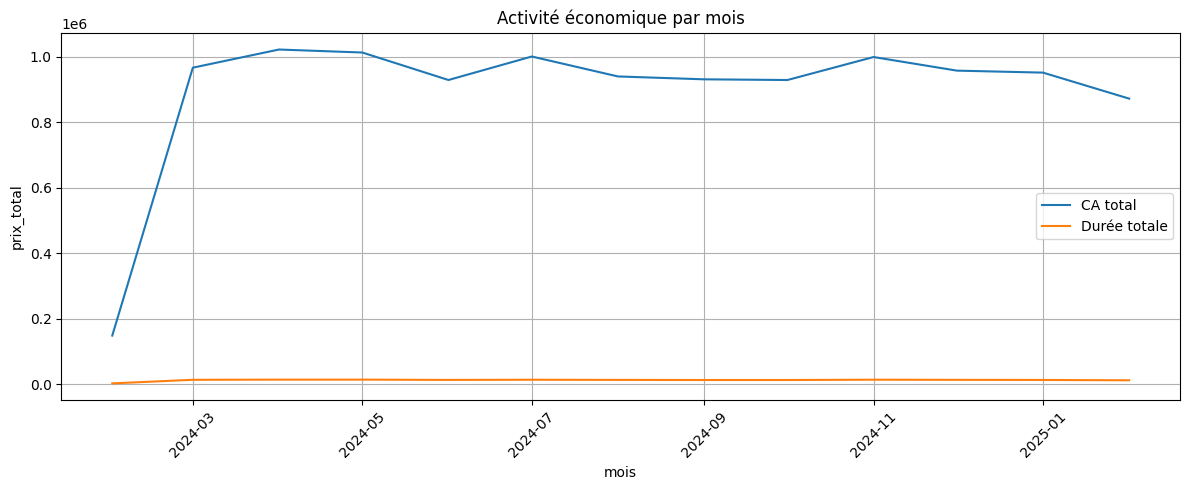

In [ ]:
activite_mois = master_df.groupby('mois').agg({
    'prix_total': 'sum',
    'duree_location': 'sum',
    'location_id': 'count'
}).reset_index()
activite_mois['mois'] = pd.to_datetime(activite_mois['mois'])

# Graphique combiné
plt.figure(figsize=(12, 5))
sns.lineplot(data=activite_mois.sort_values('mois'), x='mois', y='prix_total', label='CA total')
sns.lineplot(data=activite_mois.sort_values('mois'), x='mois', y='duree_location', label='Durée totale')
plt.title("Activité économique par mois")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
clients_df = master_df.groupby('client_id').agg({
    'prix_total': 'sum',
    'duree_location': 'sum',
    'note': 'mean',
    'location_id': 'count',
    'revenu_annuel': 'first'
}).reset_index()

clients_df.columns = ['client_id', 'ca_total', 'duree_totale', 'note_moyenne', 'nb_locations', 'revenu_annuel']


In [ ]:
top_clients = clients_df.sort_values('ca_total', ascending=False).head(10)
print(top_clients)


      client_id  ca_total  duree_totale  note_moyenne  nb_locations  \
1002       1140  12713.33           119      1.833333             6   
1120       1278  12260.87           132      2.333333             6   
2112       2412  12065.80           132      1.857143             7   
3763       4316  11655.86           124      0.888889             9   
1382       1584  11460.70           124      3.600000             5   
196         223  10943.09           119      1.800000             5   
844         960  10890.15           122      1.857143             7   
3335       3822  10399.98           133      3.142857             7   
1579       1809  10268.59           108      1.250000             4   
1589       1820  10141.44           109      3.166667             6   

      revenu_annuel  
1002        21403.0  
1120        46519.0  
2112        40008.0  
3763            0.0  
1382        47643.0  
196         66902.0  
844         29837.0  
3335        29873.0  
1579        35874.0 

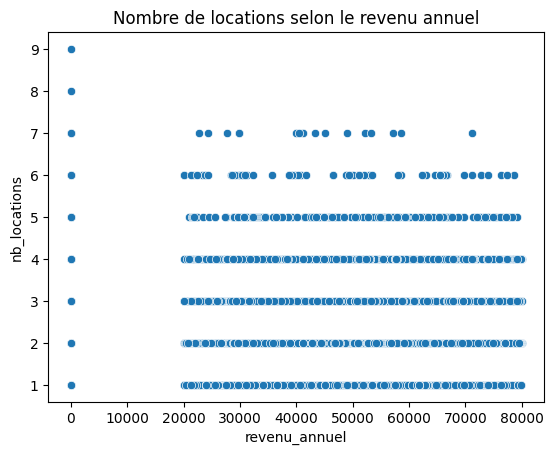

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=clients_df, x='revenu_annuel', y='nb_locations')
plt.title("Nombre de locations selon le revenu annuel")
plt.show()


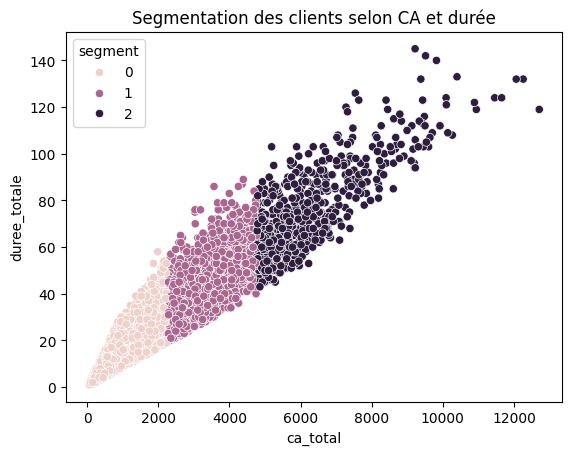

In [ ]:
from sklearn.cluster import KMeans

X = clients_df[['ca_total', 'duree_totale', 'nb_locations']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
clients_df['segment'] = kmeans.labels_

sns.scatterplot(data=clients_df, x='ca_total', y='duree_totale', hue='segment')
plt.title("Segmentation des clients selon CA et durée")
plt.show()


In [ ]:
clients_df['segment'] = kmeans.labels_


In [ ]:
pd.crosstab(master_df['segment'], master_df['type_vehicule'])


KeyError: 'segment'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer un tableau groupé
vehicule_par_segment = master_df.groupby(['segment', 'type_vehicule'])['location_id'].count().reset_index()
vehicule_par_segment.columns = ['segment', 'type_vehicule', 'nb_locations']

# Affichage
plt.figure(figsize=(10, 6))
sns.barplot(data=vehicule_par_segment, x='segment', y='nb_locations', hue='type_vehicule')
plt.title("Répartition des types de véhicules par segment client")
plt.xlabel("Segment client")
plt.ylabel("Nombre de locations")
plt.legend(title='Type de véhicule')
plt.tight_layout()
plt.show()


KeyError: 'segment'

In [ ]:
clients_df = master_df.groupby('client_id').agg({
    'prix_total': 'sum',
    'duree_location': 'sum',
    'note': 'mean',
    'location_id': 'count',
    'revenu_annuel': 'first'
}).reset_index()

clients_df.columns = ['client_id', 'ca_total', 'duree_totale', 'note_moyenne', 'nb_locations', 'revenu_annuel']

from sklearn.cluster import KMeans

X = clients_df[['ca_total', 'duree_totale', 'nb_locations']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
clients_df['segment'] = kmeans.labels_


In [ ]:
vehicule_par_segment = master_df.groupby(['segment', 'type_vehicule'])['location_id'].count().reset_index()

sns.barplot(data=vehicule_par_segment, x='segment', y='location_id', hue='type_vehicule')
plt.title("Répartition des types de véhicules par segment client")
plt.xlabel("Segment client")
plt.ylabel("Nombre de locations")
plt.legend(title='Type de véhicule')
plt.tight_layout()
plt.show()


KeyError: 'segment'